## Define the Convolutional Neural Network

In this notebook and in `models.py`:

1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

---


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

input_image_size = 224
depth = 1

# Instantiate the network
from models import Net

net = Net(input_image_size, depth)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kern

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

In [3]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# the transforms defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Normalize, ToTensor, RandomCrop, Rescale, RandomRescale


# define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([RandomRescale(input_image_size),
                                     RandomCrop(input_image_size),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(10):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    assert sample['image'].size() == (depth, input_image_size, input_image_size)

Number of images:  3452
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
5 torch.Size([1, 224, 224]) torch.Size([68, 2])
6 torch.Size([1, 224, 224]) torch.Size([68, 2])
7 torch.Size([1, 224, 224]) torch.Size([68, 2])
8 torch.Size([1, 224, 224]) torch.Size([68, 2])
9 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

In [6]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

In [198]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='y')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


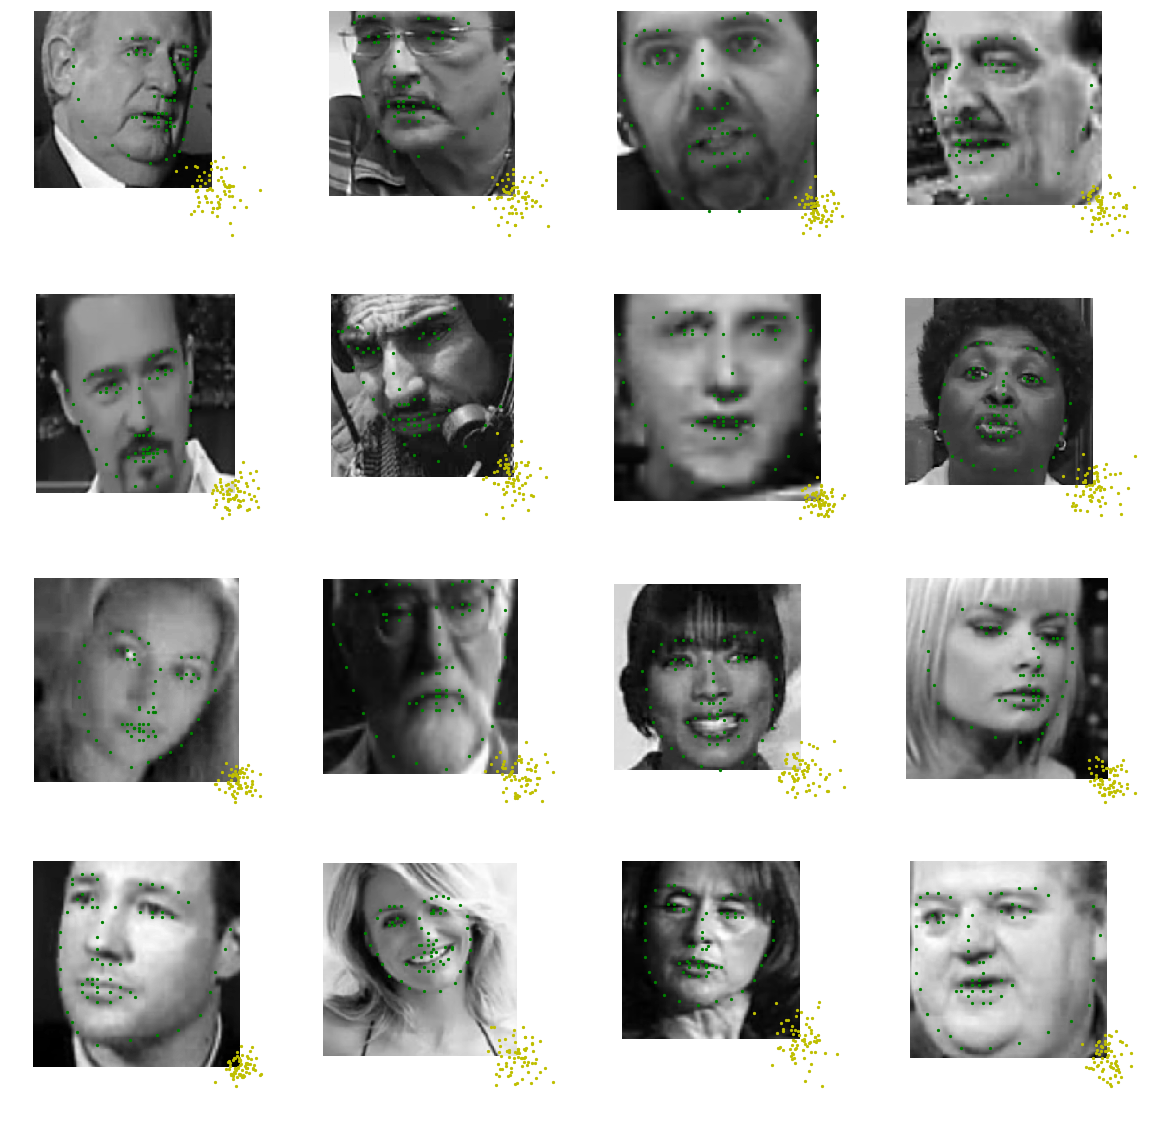

In [197]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, batch_size, gt_pts=None):

    plt.figure(figsize=(20, 20))
    
    for i in range(batch_size):
        
        ax = plt.subplot(4, batch_size/4, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  

        predicted_key_pts = predicted_key_pts*(image.shape[0]/2)+(image.shape[0])

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]  
            ground_truth_pts = (ground_truth_pts*(image.shape[0]/2))+(image.shape[0])
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, batch_size, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [199]:
# define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss(size_average=False)

optimizer = optim.RMSprop(net.parameters(), lr=0.005)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
import math

loss_over_time = [] # to track the loss as the network trains

def train_net(n_epochs):
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            #print(loss.item())
            if batch_i % 27 == 26:    # print every 27 batches
                avg_loss = running_loss / 27
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}/{}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, math.ceil(len(transformed_dataset)/batch_size), avg_loss))
                running_loss = 0.0

    print('Finished Training')


In [15]:
import time

# train the network
n_epochs = 96 # start small, and increase when you've decided on your model structure and hyperparams

print( "Start time: " + time.strftime('%X %x %Z'))
train_net(n_epochs)
print( "End time: " + time.strftime('%X %x %Z'))

Start time: 05:10:02 05/09/18 Mitteleuropäische Sommerzeit
Epoch: 1, Batch: 27/216, Avg. Loss: 74865.72064661096
Epoch: 1, Batch: 54/216, Avg. Loss: 121.97637840553567
Epoch: 1, Batch: 81/216, Avg. Loss: 111.1014641655816
Epoch: 1, Batch: 108/216, Avg. Loss: 125.15965892650463
Epoch: 1, Batch: 135/216, Avg. Loss: 105.92535456904659
Epoch: 1, Batch: 162/216, Avg. Loss: 99.48377722280996
Epoch: 1, Batch: 189/216, Avg. Loss: 77.83824087072301
Epoch: 1, Batch: 216/216, Avg. Loss: 83.73096070466218
Epoch: 2, Batch: 27/216, Avg. Loss: 79.10899988810222
Epoch: 2, Batch: 54/216, Avg. Loss: 78.05450510095667
Epoch: 2, Batch: 81/216, Avg. Loss: 70.42836337619357
Epoch: 2, Batch: 108/216, Avg. Loss: 69.31278779771593
Epoch: 2, Batch: 135/216, Avg. Loss: 68.89301794546621
Epoch: 2, Batch: 162/216, Avg. Loss: 65.2207514444987
Epoch: 2, Batch: 189/216, Avg. Loss: 72.09038190488462
Epoch: 2, Batch: 216/216, Avg. Loss: 71.54390532882125
Epoch: 3, Batch: 27/216, Avg. Loss: 73.86324098375108
Epoch: 3, B

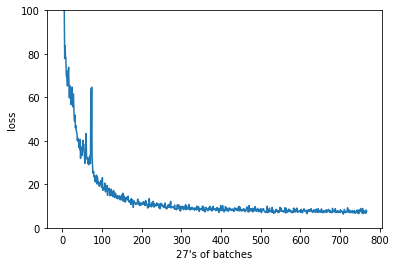

In [16]:
# visualize the loss as the network trained
plt.plot(loss_over_time)
plt.xlabel('27\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 150) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [321]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


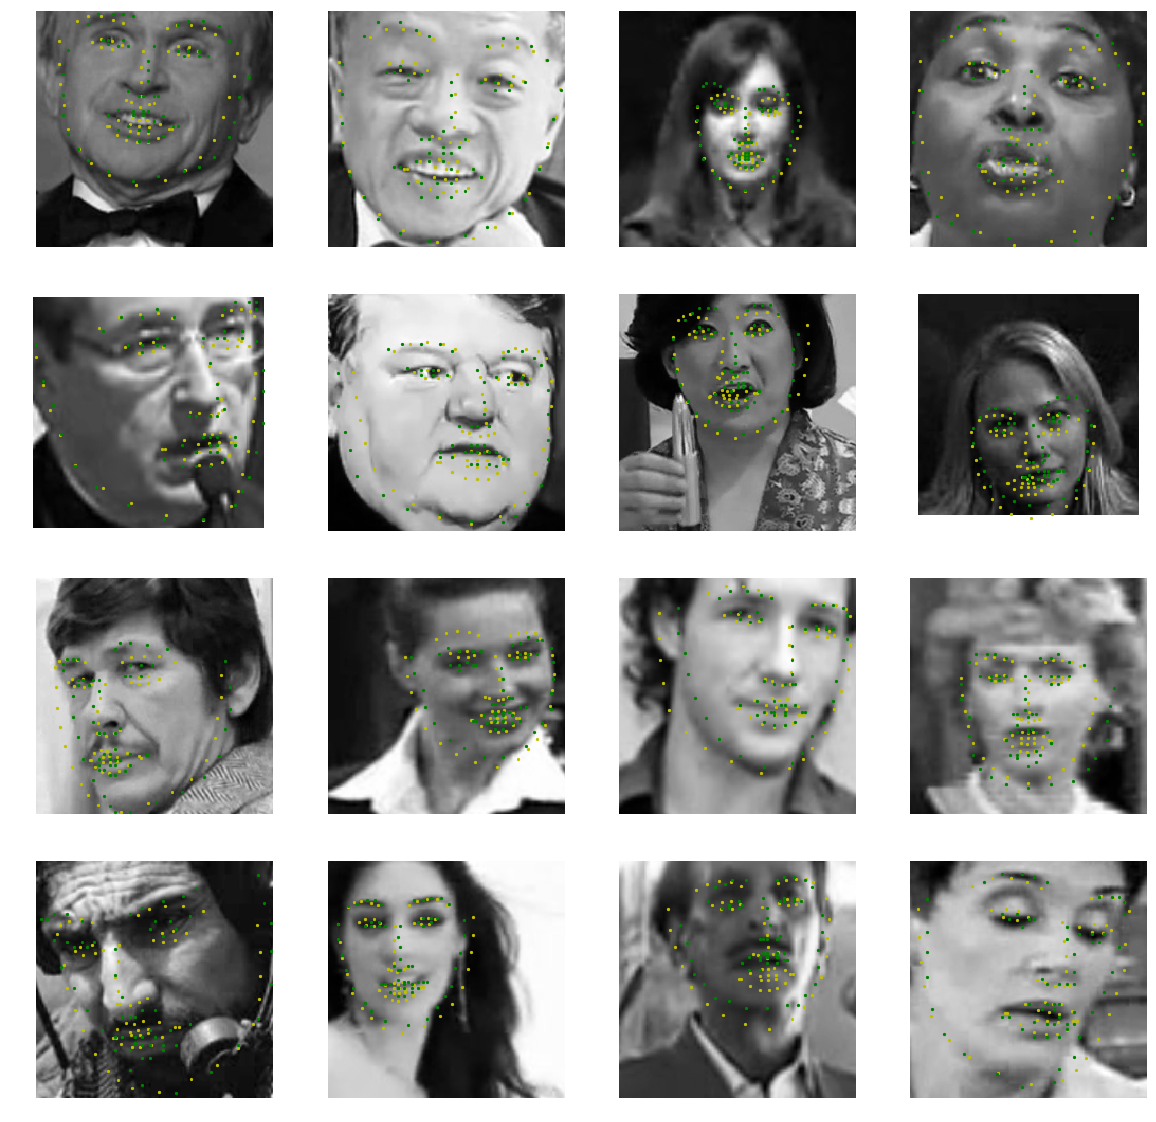

In [204]:
# visualize your test output
visualize_output(test_images, test_outputs, batch_size, gt_pts)

### Save the model

In [19]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_4.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
SmoothL1Loss was choosed for the loss function because it is less sensitive to outliers than the MSELoss.

For the optimizer RMSprop (Root Mean Square Propagation) was choosed because it adapts the learning rate and has shown excellent adaptation of learning rate in different applications. Compaared to the Adam optimization algorithm it showed a better performens within the first epoch in the initial training observation phase while taking the same time.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with a small CNN with 2 convolutional layers and one linear layer. During observation i added several more convolutional layers and linear layers using VGG-16 architecture as an orientation. Still having no good results after around 20 epochs ( the prediction was returning the same facial keypoints for every test image ), I decided to add several dropout layers. But the biggest improvemnt could be achived with adding batch normalization layers to the network.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Empirical with testing batch sizes of 4, 8, 10, 16 and 20. The number of 96 epochs was choosed to get an result within 8 hours.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In [202]:
# Load the model again
import torch
from models import Net

input_image_size = 224
depth = 1

net = Net(input_image_size, depth)

# Load the best saved model parameters 
net.load_state_dict(torch.load('saved_models/keypoints_model_3.pt'))

# print out net and prepare it for testing 
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kern

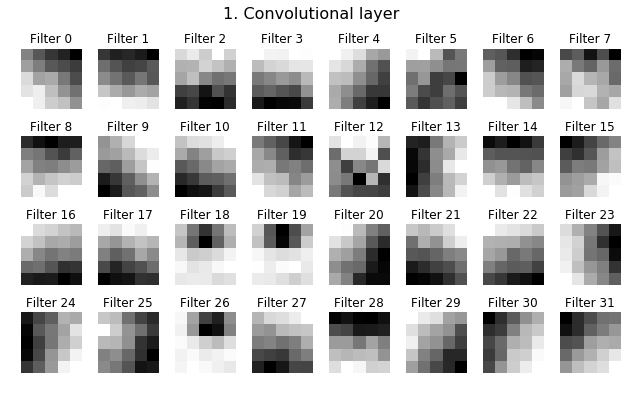

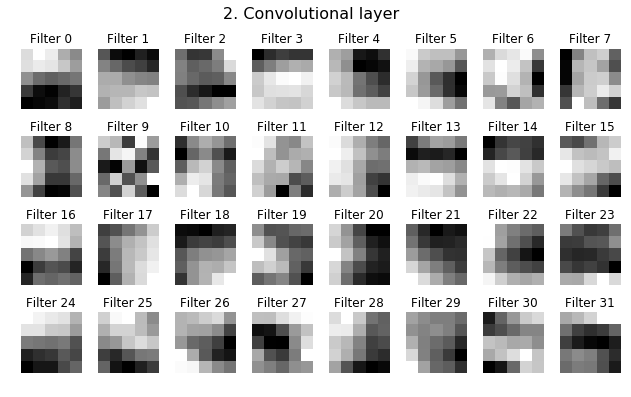

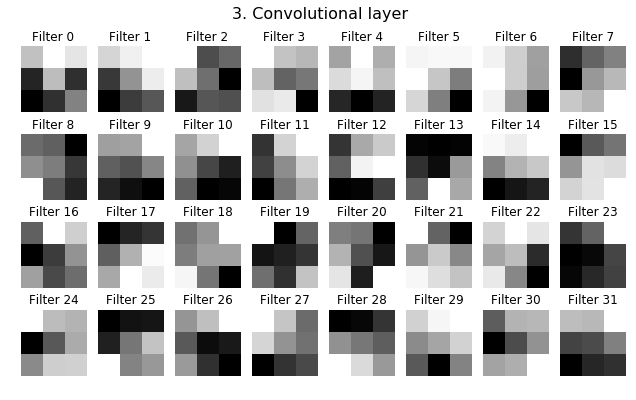

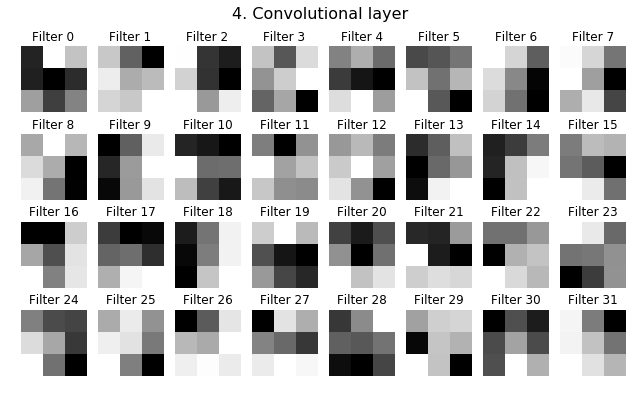

In [292]:
import matplotlib.pyplot as plt
import numpy as np

# display the filter weights
def showWeights(weigths, title):
    plt.close('all')

    fig = plt.figure(figsize=(9,9))
    fig.suptitle(title, y=1.01, fontsize=16)
    for filter_index in range(w.shape[0]):
        sub = plt.subplot(4,8,filter_index+1)
        sub.set_title("Filter " + str(filter_index))
        plt.imshow(weigths[filter_index][0], cmap='gray')
        plt.axis('off')

    fig.tight_layout(rect=[0, 0.4, 1, 0.99], w_pad=-1.0)
    plt.show()
    return
    
weights1 = net.conv1.weight.data
showWeights(weights1.numpy(), "1. Convolutional layer")

weights2 = net.conv2.weight.data
showWeights(weights2.numpy(), "2. Convolutional layer")

weights3 = net.conv3.weight.data
showWeights(weights3.numpy(), "3. Convolutional layer")

weights4 = net.conv4.weight.data
showWeights(weights4.numpy(), "4. Convolutional layer")

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. 

---

### Filter an image to see the effect of a convolutional kernel

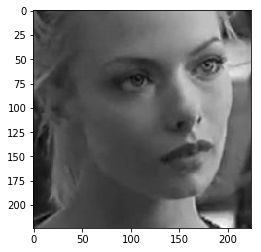

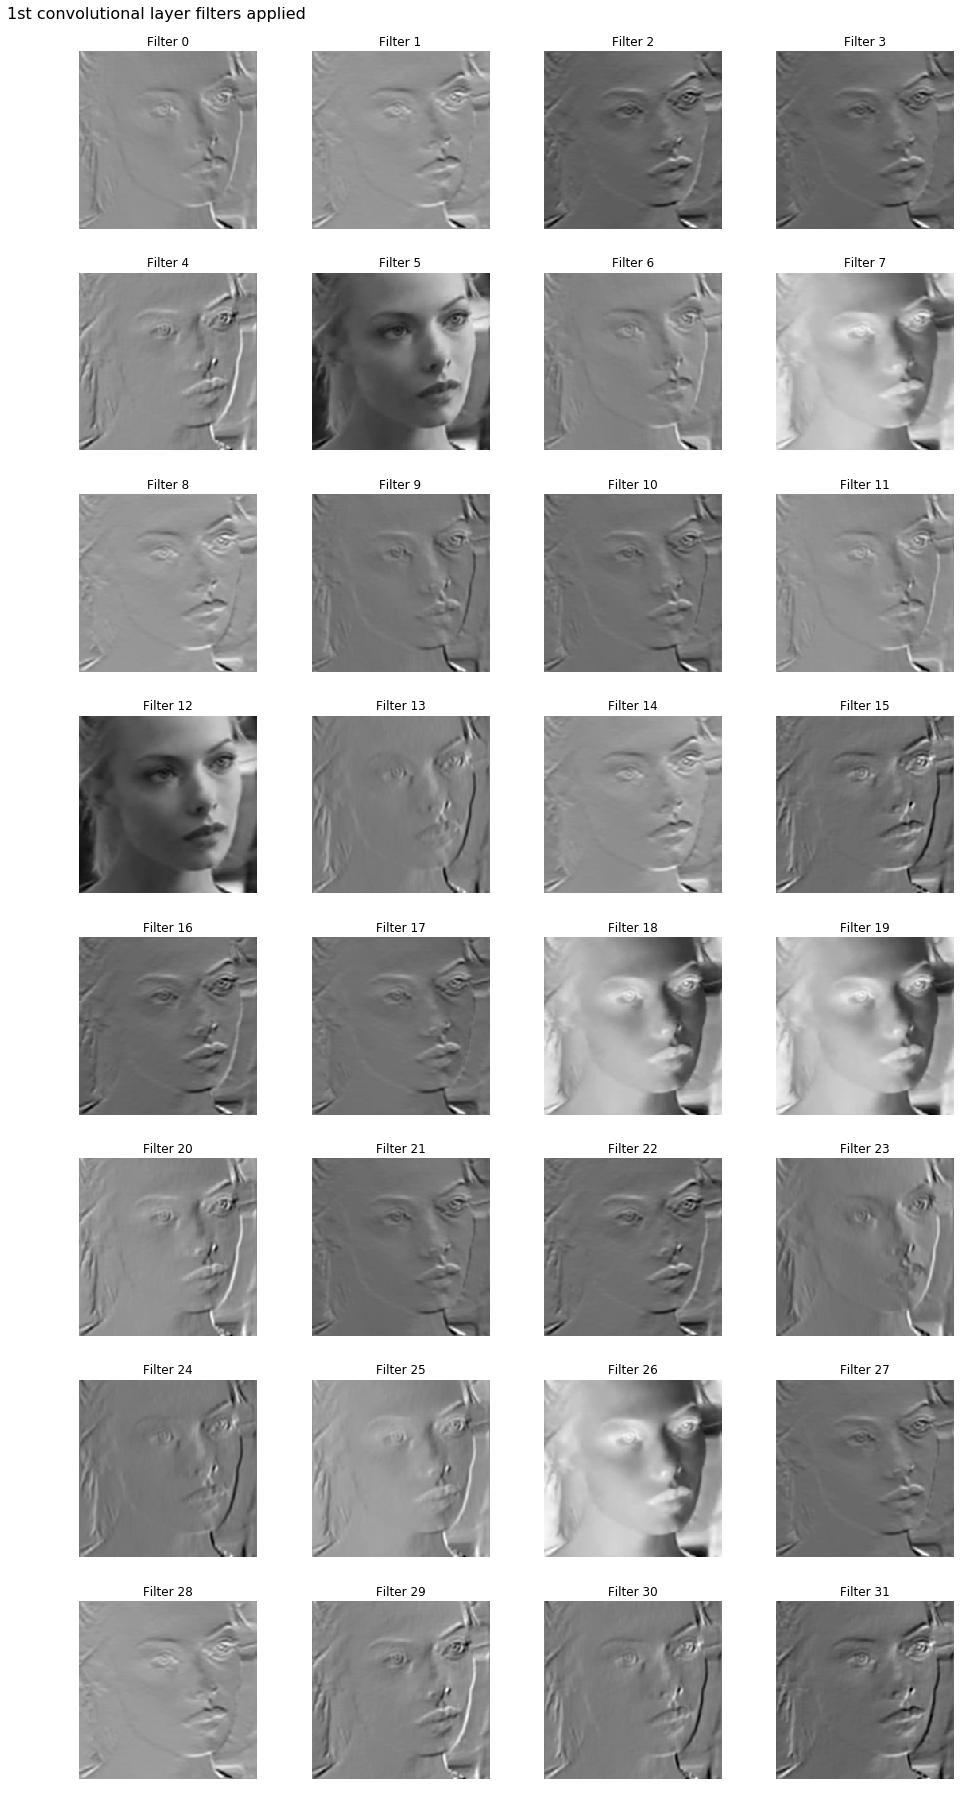

In [338]:
import cv2

#load in and display any image from the transformed test dataset
image = test_images[8].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.squeeze(np.transpose(image, (1, 2, 0)))   # transpose to go from torch to numpy image
plt.imshow(image, cmap='gray')
plt.show()

plt.close('all')

fig = plt.figure(figsize=(25,25))
fig.suptitle("1st convolutional layer filters applied", fontsize=16, y=1.0)
    
for filter_index in range(net.conv1.weight.data.shape[0]):
    weights = net.conv1.weight.data[filter_index][0]
    filtered_image = cv2.filter2D(image, -1, weights.numpy())
    sub = plt.subplot(8,4,filter_index+1)
    sub.set_title("Filter " + str(filter_index))
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    
fig.tight_layout(rect=[0.4, 0.0, 1, 0.99], w_pad=0.0)
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: 
Filter 7, 18, 19 and 26 produce a negative of the image, emphasizing dark parts of the image like shadows around the nose, eyes or chin. 

Filter 5 and 12 seems to have no big impact on the image. I assume it is used for noise reduction.

The rest of the filters seems to be for edge dections in several directions. For example Filter 1, 8, 14 and 28 emphasizing transitions from dark to bright areas in the image in vertical direction. I assume it is used for detecting the lower edges of eyebrows and lips. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!